In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from settings  import *
from preprocessing import *
from models import Relative_Positioning, StagerNet
import mne
from dataset import RP_Dataset, WeightedSampler
from train import train_ssl
from importlib import reload
import process 
import preprocessing as pr
reload(process)

<module 'process' from '/home/brain/EEG-ssl/process.py'>

In [2]:
subject = '01'
# models params
C = 64
T =1000
M = 200
#training paramms
epochs = 20
batch_size = 40
lr = 1e-3
resume = False
#datasets params
n_train = 4000
n_test = 500
#sampling params
pos= 3000
neg = 7000

s_weights = [0.5, 1-0.5]


In [3]:
import torch
from torch.nn import *
from pylab import *
from torch import optim
from torch.utils import data
from torch import nn
from torch.nn.functional import soft_margin_loss

In [5]:
DEVICE = torch.device("cpu"); DEVICE

device(type='cpu')

In [8]:
class DecoderSampler(torch.utils.data.sampler.Sampler):
    r"""Sample des windows randomly
    Arguments:
    ---------
        dataset (Dataset): dataset to sample from
        size (int): The total number of sequences to sample
    """

    def __init__(self,dataset, batch_size,size,  weights):
    
        
        self.batch_size = batch_size
        self.size = size
        self.dataset = dataset
        self.weights = torch.DoubleTensor(weights)
        
    def __iter__(self):
        num_batches = self.size// self.batch_size
        while num_batches > 0:
            #print()
            sampled = 0
            while sampled < self.batch_size:
                indice  = torch.multinomial(
            self.weights, 1, replacement=True)
                target = STIMULUS_IDS[indice]
                t = choice(arange(0, 5, 1))
                
                sampled += 1
                yield ( target,t)
            
            num_batches -=1

    def __len__(self):
        return len(self.train_list)   
class  Decoder_Dataset(torch.utils.data.Dataset):
    '''
    Classe dataset  pour les differents sampling
    '''
    def __init__(self, data_dict, T , step):

        self.data_dict = data_dict
        self.temp_len = T
        self.step = step
    def __getitem__(self, index):
        classe = index[0]
        print(index)
        sample = self.data_dict[classe][index[1]].get_data()
        return torch.tensor(sample).to(DEVICE).unfold(-1,T, self.step ).permute(2,0,1,3), classe
    def __len__(self): len(self.data_dict)*len(data_dict[1])
        
class Decoder(nn.Module):
    
    def __init__(self, EEG_FeatureExtractor, aggregator,  C, T, embedding_dim=100, hidden_dim= 20):
        super().__init__()
        self.feature_extractor = EEG_FeatureExtractor
        #self.feature_extractor.float()
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 12)
        self.aggr = aggregator
        self.loss_fn = nn.CrossEntropyLoss()
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        with torch.no_grad():
            x = self.feature_extractor(x)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        out = self.aggr(x, axis = 0)
        return out
    
        

In [9]:
def _train_dec(model, train_loader, optimizer, epoch):
    
	model.train()
	train_losses = []
    
	for x, y in train_loader:
		
		y = y.to(DEVICE).to(float).contiguous()
		loss = model.loss_fn(model(x), y)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_losses.append(loss.item())
	return train_losses
def _train_epochs_dec(model, train_loader, test_loader, train_args):
	epochs, lr = train_args['epochs'], train_args['lr']
	optimizer = optim.Adam(model.parameters(), lr=lr)
	if not os.path.exists(SAVED_MODEL_DIR):
		os.makedirs(SAVED_MODEL_DIR)
	
	train_losses = []
	test_losses = [_eval_loss_dex(model, test_loader)]
	for epoch in range(1, epochs+1):
		model.train()
		train_losses.extend(_train_dec(model, train_loader, optimizer, epoch))
		test_loss = _eval_loss_dec(model, test_loader)
		test_losses.append(test_loss)
		print(f'Epoch {epoch}, Test loss {test_loss:.4f}')
		
		# save model every 10 epochs
		if epoch % 2 == 0:
			torch.save(model.state_dict(), os.path.join(ROOT, 'saved_models', 'decoder_epoch{}.pt'.format(epoch)))
	torch.save(model.state_dict(), os.path.join(ROOT, 'saved_models', 'decoder.pt'))
	return train_losses, test_losses

def _eval_loss_dec(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in data_loader:
            loss = model.loss_fn(model(x), y)
            total_loss += loss * x[0].shape[0] # 
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_decoder(model, train_dataset, test_dataset,sampler, n_epochs=20, lr=1e-3, batch_size=256, load_last_saved_model=False, num_workers=8):
	
	
	if load_last_saved_model:
		model.load_state_dict(torch.load(os.path.join(ROOT, SAVED_MODEL_DIR, 'decoder.pt')))

	if torch.cuda.device_count() > 1:
		model = nn.DataParallel(model)
        
	model.to(DEVICE)
    
   

	train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=0,sampler = sampler)
	test_loader = torch.utils.data.DataLoader(test, num_workers=0,sampler = sampler)
	new_train_losses, new_test_losses = _train_epochs_dec(model, train_loader, test_loader, 
																				 dict(epochs=n_epochs, lr=lr))

	if load_last_saved_model:
		train_losses, test_losses = load_losses(SAVED_MODEL_DIR, 'decoder')
	else:
		train_losses = []
		test_losses = []
	
	train_losses.extend(new_train_losses)
	test_losses.extend(new_test_losses)

	save_losses(train_losses, test_losses, SAVED_MODEL_DIR, 'decoder')

	return train_losses, test_losses, model

In [10]:
data_dict = process.get_features('01', condition = 1)

Opening raw data file /home/brain/openmiir/raw_data/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
Reading /home/brain/openmiir/eeg/preprocessing/ica/P01-100p_64c-ica.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
Now restoring ICA solution ...
Ready.
Transforming to ICA space (61 components)
Zeroing out 4 ICA components
540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]
-1e-06 14.9481
-1e-06 9.5011
-1e-06 11.9797
-1e-06 14.6112
-1e-06 15.1175
-1e-06 9.6427
-1e-06 11.3142
-1e-06 15.2131
-1e-06 10.321

In [11]:
ssl_model = Relative_Positioning(StagerNet,C , T, embedding_dim = M )
ssl_model.load_state_dict(torch.load(os.path.join(ROOT, 'saved_models', 'ssl_model.pt')))
model = ssl_model.feature_extractor

aggregator = torch.mean
decoder = Decoder(model, aggregator, C, T, embedding_dim=M, hidden_dim = 20)
decoder.to(float).to(DEVICE)
dataset = Decoder_Dataset(data_dict, T, step = 512)
sampler = DecoderSampler(dataset, batch_size = 12, weights = [1/12]*12, size = 65)

In [12]:
decoder.to(DEVICE)

Decoder(
  (feature_extractor): StagerNet(
    (relu): ReLU()
    (spatial_conv): Conv2d(1, 64, kernel_size=(64, 1), stride=(1, 1))
    (temp_conv1): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25))
    (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (temp_conv2): Conv2d(16, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25))
    (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxPool): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten()
    (dropout): Dropout(p=0.5, inplace=False)
    (linear_class): Linear(in_features=5120, out_features=200, bias=True)
  )
  (linear1): Linear(in_features=200, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=12, bias=True)
  (loss_fn): CrossEntropyLoss()
  (relu): ReLU()
)

In [4]:
raw = get_raw('01')

Opening raw data file /home/brain/openmiir/raw_data/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...


In [7]:
def reconstuct_signal(raw, ica):
    """
    a function to get the reconstruct eeg signal from raw using the computed ICs 
    parameters:
    -----------
    - raw : mne RAW object
    - ica : mne ICA object

    
    returns: numpy array
    -------
    """
    signal = ica.apply(raw)
    picks = mne.pick_types(signal.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])
    return signal.get_data(picks)
       
def process(subject):
    """
    a function to get preprocessed eeg signal for a single subject

    """
    # Bandpass filtring 
    raw = get_raw(subject)
    ica = get_ica(subject)
    
    return reconstuct_signal(raw, ica)


In [5]:
#del raw, ica
raw = get_raw('04')
ica = get_ica('04')
signal = ica.apply(raw)
picks = mne.pick_types(signal.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])
a = signal.get_data(picks)
a.shape

Opening raw data file /home/brain/openmiir/raw_data/P04-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2480032 =      0.000 ...  4843.812 secs
Ready.
Reading 0 ... 2480032  =      0.000 ...  4843.812 secs...
Reading /home/brain/openmiir/eeg/preprocessing/ica/P04-100p_64c-ica.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
Now restoring ICA solution ...
Ready.
Transforming to ICA space (63 components)
Zeroing out 2 ICA components


(64, 2480033)

In [7]:
eeg_signal = pr.process('01')

Opening raw data file /home/brain/openmiir/raw_data/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
Reading /home/brain/openmiir/eeg/preprocessing/ica/P01-100p_64c-ica.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
Now restoring ICA solution ...
Ready.
Transforming to ICA space (61 components)
Zeroing out 4 ICA components


In [9]:
eeg_signal.shape

(64, 2478166)

In [10]:
print( "Training parameters:")
print("======================")
print(f"- subject: {subject}\n- C : {C}\n- T : {T}\n- M : {M}\n- epochs : {epochs}\n- batch size : {batch_size}\n- lr : {lr}\n- n_train : {n_train}\n- n_test : {n_test}\n- pos : {pos}\n- neg : {neg}")

X = eeg_signal
#split data
split = int(X.shape[1]*0.6)
X_train = X[:, :split]
X_test = X[:, split:]

Training parameters:
- subject: 01
- C : 64
- T : 1000
- M : 200
- epochs : 20
- batch size : 40
- lr : 0.001
- n_train : 4000
- n_test : 500
- pos : 3000
- neg : 7000


NameError: name 'eeg_signal' is not defined

In [21]:
def main(model_name : str, data : List[torch.tensor], epochs : int, C : int, T : int, M : int, batch_size : int, n_train : int, 
         n_test: int , s_weights : List[float], pos : int, neg : int, lr : float = 1e-3 ):
    #define ssl model
    X_train = data[0]
    X_test = data[1]
    ssl_model = Relative_Positioning(StagerNet,C , T, embedding_dim = M )
    ssl_model.to(float)
    # datasets
    train_dataset =  RP_Dataset(X_train, sampling_params = (pos, neg), temp_len = T ,
                                n_features = C )
    test_dataset =  RP_Dataset(X_test, sampling_params = (pos, neg), temp_len = T ,
                                n_features = C )

    train_sampler = WeightedSampler(train_dataset, batch_size = batch_size ,size = n_train,  
                              weights = s_weights)
    test_sampler = WeightedSampler(test_dataset, batch_size = batch_size ,size = n_test,  
                              weights = s_weights)
    samplers = {"train" : train_sampler, "val": test_sampler}


    #train ssl 
    train_losses, test_losses, model = train_ssl(ssl_model, train_dataset, test_dataset,
                                                 samplers,n_epochs=epochs, lr=lr,batch_size= batch_size, 
                                                 load_last_saved_model=False, num_workers= 0)

    return train_losses, test_losses, model


Epoch 1, Test loss 0.0003
Epoch 2, Test loss 0.0003
Epoch 3, Test loss 0.0003
Epoch 4, Test loss 0.0002
Epoch 5, Test loss 0.0002
Epoch 6, Test loss 0.0002
Epoch 7, Test loss 0.0002
Epoch 8, Test loss 0.0002
Epoch 9, Test loss 0.0002
Epoch 10, Test loss 0.0002
Epoch 11, Test loss 0.0002
Epoch 12, Test loss 0.0002
Epoch 13, Test loss 0.0002
Epoch 14, Test loss 0.0002
Epoch 15, Test loss 0.0002
Epoch 16, Test loss 0.0002
Epoch 17, Test loss 0.0002
Epoch 18, Test loss 0.0002
Epoch 19, Test loss 0.0002
Epoch 20, Test loss 0.0002


In [4]:
data_dict = process.get_features('01', condition = 1)

Opening raw data file /home/brain/openmiir/raw_data/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
Reading /home/brain/openmiir/eeg/preprocessing/ica/P01-100p_64c-ica.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
Now restoring ICA solution ...
Ready.
Transforming to ICA space (61 components)
Zeroing out 4 ICA components
540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]
-1e-06 14.9481
-1e-06 9.5011
-1e-06 11.9797
-1e-06 14.6112
-1e-06 15.1175
-1e-06 9.6427
-1e-06 11.3142
-1e-06 15.2131
-1e-06 10.321

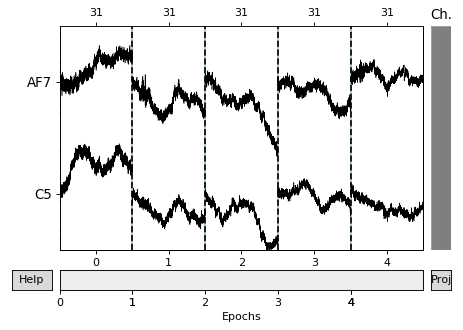

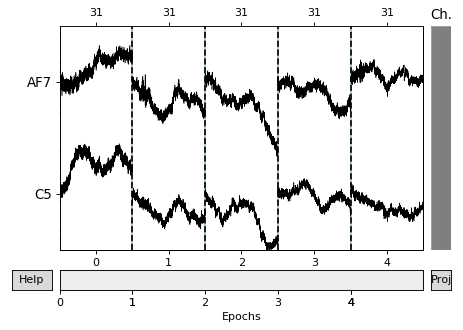

In [26]:
data_dict[3].plot(n_epochs = 6, picks = [1,13])

In [38]:
def visualise_epochs(subject, signal, stim_id, condition = 1,picks=None):

    events = get_events(signal)
    epochs = process.get_trial_epochs(signal, events, stim_id = stim_id, condition= condition,
                     subject=subject, stimuli_version=None, meta=None,
                     include_cue=True, picks=picks, debug=False)
    epochs.plot(n_epochs = 10)



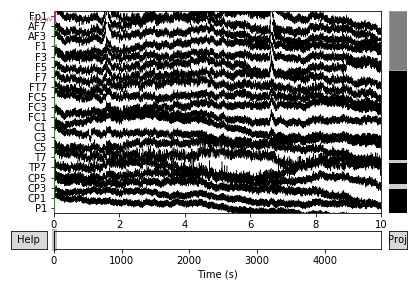

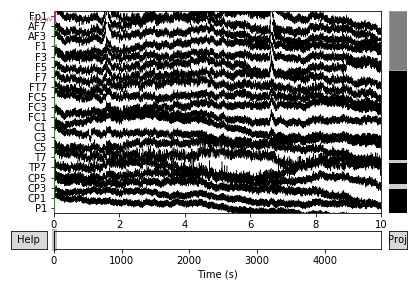

In [21]:
raw.plot()

Reading /home/brain/openmiir/eeg/preprocessing/ica/P01-100p_64c-ica.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
Now restoring ICA solution ...
Ready.
Transforming to ICA space (61 components)
Zeroing out 4 ICA components


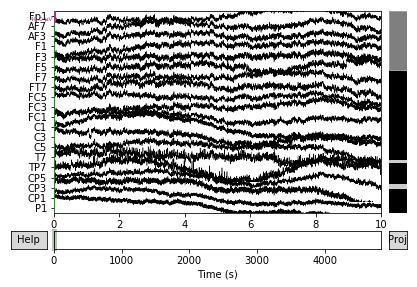

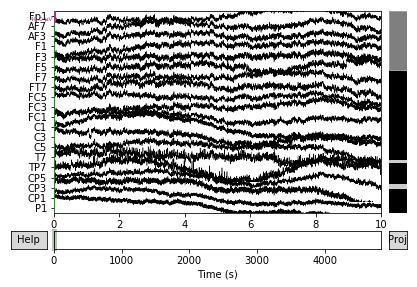

In [31]:
ica = get_ica('01')
rec = ica.apply(raw)
rec.plot()

540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]
-1e-07 14.9481


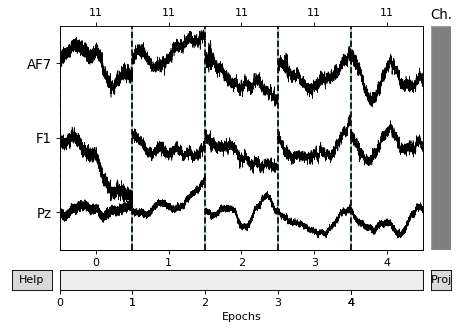

In [45]:
visualise_epochs(subject = '01', signal = raw, stim_id = 1, condition = 1, picks = [1,3,30])

540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]
-1e-07 14.9481


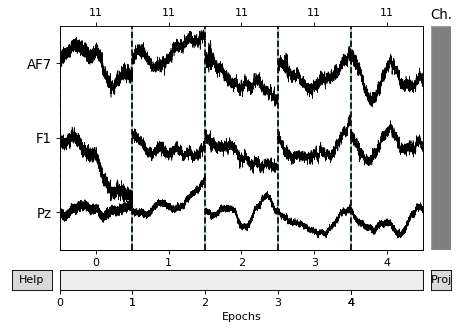

In [43]:
visualise_epochs(subject = '01', signal = rec, stim_id = 1, condition = 1, picks = [1,3,30])

In [12]:
events = mne.find_events(raw, stim_channel='STI 014', output = 'offset')

540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]


In [13]:
meta = load_stimuli_metadata(data_root = METADATA_DIR,version= 2)

## Decoders

In [158]:
x_sample.shape

(1, 64, 4866)

In [50]:
x_sample = data_dict[2][0].get_data()

In [51]:
x_sample.shape

(1, 64, 4866)

In [104]:
x = torch.tensor(x_sample).to(DEVICE).unfold(-1,1000, 512 ).permute(2,0,1,3)

In [159]:
x.shape

torch.Size([8, 1, 64, 1000])